In [1]:
from models import *
from datetime import datetime
from random import random
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os

# Initiate parameters
start_date = '2019-01-01'  
end_date = '2023-03-12'
ticker = 'bac'
period = "1wk" 
shuffle = True

# Sentiment types... APISentiment	VaderSentiment	CombinedVaderSentiment RobertaLargeSentiment #TwitterSentiment
sentiment = True
sentiment_type = 'TwitterSentiment'
aggr_function = 'median'

#Setup windows
formation_window = 4
target_window = 1

#Split Ratios
split_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

#trade condition
condition = False

# EMA indicators
indicator1 = 5
indicator2 = 8
indicator3 = 21

# training batches
batch_size_train = 6
batch_size_valid = 2

#Clear Folders
delete = True
export_excels = False

#__________________________________________________
# Do not change
api_key = '631505e804ec58.42743136'
window_size = formation_window + 1

if sentiment == False:
    news_df = None
if sentiment_type == 'TwitterSentiment':
    twitter = True
else:
    twitter = False

excel_reports = ".\Excel reports"
temp = f".\TempFiles\{ticker}"

#Delete folders
if delete == True:
    try:
        shutil.rmtree(excel_reports)
        shutil.rmtree(temp)
    except:
        pass
    # Create folder, if exist pass exception
    try:
        os.mkdir("Excel reports")
        os.mkdir(f"TempFiles\{ticker}")
    except:
        pass

# Print stuffs
print("\nTensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("\nwindow size: ", window_size)
print("formation_window: ", formation_window)
print("target_window: ", target_window)
print("chart period: ", period)



Tensorflow version:  2.9.1
Numpy version:  1.23.1

window size:  5
formation_window:  4
target_window:  1
chart period:  1wk


In [2]:
if sentiment == True:

    from sentiment import GetNews

    GetNewsAPI = GetNews()

    GetNewsAPI.fit(ticker=ticker, start_date=start_date, end_date=end_date,
                   n_news=1000, token=api_key, offset=0, export_excel=True, twitter=twitter,temp_folder=temp)
    news_df = GetNewsAPI.transform()
news_df.shape


d:\MachineLearning\DataScience\VSCode\04_StockPrediction\04_stockprediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--------> GetNews completed



(427, 2)

In [3]:
from transformers_preprocess import PullData

GetData = PullData()

print("ticker: ",ticker)

GetData.fit(ticker=ticker,
            start_date=start_date,
            end_date=end_date,
            interval=period,  
            progress=False,
            condition=condition,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=indicator1,
            timeperiod2=indicator2,
            timeperiod3=indicator3,
            export_excel=export_excels,
            excel_path=excel_reports,
            listed_conditions=None,
            sentiment=sentiment,
            sentiment_type=sentiment_type, 
            news_df=news_df,
            chart_period=period,
            sentiment_aggr=aggr_function,
            )

data_prep = GetData.transform()

# Validation
if window_size != (formation_window + 1):
    raise Exception(
        f"Error - window_size ({window_size}) must be equal to sum of formation_window ({formation_window}) and value 1.")
data_prep.shape


ticker:  tsla
initial shape:  (220, 6)


(1075, 10)

In [4]:
####################################################################

from transformers_preprocess import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=window_size, shuffle=shuffle, debug=False,
                  export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment)

data_normalized, Dates = NormalizeData.transform(data_prep)
data_normalized.head(8)
# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast
#Dates



Dataframe shape:  (1075, 10)
Number of formations:  215
--------> NormalizeData completed



,Open,High,Low,Close,EMA5,EMA8,EMA21,TwitterSentiment,maxv,minv
0,0.544597,0.788737,0.427729,0.465044,0.452480,0.321736,0.229880,0.1327,313.799988,265.73999
1,0.355597,0.473159,0.008531,0.093009,0.332656,0.270908,0.217437,0.1287,313.799988,265.73999
2,0.144403,0.709738,0.000000,0.706201,0.457171,0.367640,0.261870,0.1581,313.799988,265.73999
3,0.727840,0.902622,0.513109,0.782564,0.565635,0.459845,0.309206,0.1420,313.799988,265.73999
4,0.714732,1.000000,0.147316,0.199542,0.332656,0.270908,0.217437,0.1287,313.799988,265.73999
5,0.958976,1.000000,0.588968,0.802985,0.786013,0.768231,0.618583,0.0000,249.766663,182.32666
6,0.775109,0.785983,0.509194,0.619761,0.730596,0.735238,0.618690,0.0000,249.766663,182.32666
7,0.582839,0.583581,0.062624,0.211348,0.557513,0.618818,0.581659,0.0000,249.766663,182.32666


In [5]:
####################################################################

from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=window_size,
              dates=Dates, debug=False, export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment,validation_set=validation_ratio, test_set=test_ratio)

x_train, x_valid, x_test, x_train_x, x_valid_x, x_test_x,_ = SplitData.transform(data_normalized)
# x_train.head(25)



DF Shape:  (1075, 10)
train_split split:  750
validation split:  160
total validation windows:  65.0

Split train ratio: 70 %
Split validation ratio: 15 %
Split test ratio: 15 %

train period: 2022-08-22 - 2022-11-07
valid period: 2021-02-15 - 2021-06-14
test period: 2023-01-16 - 2019-12-16

Total Windows:  215.0
x_train windows:  150.0
x_valid windows:  32.0
x_test windows:  33.0
--------> SplitData completed



In [6]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=window_size, batch_size=batch_size_train, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

# c = 0
# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break


--------> GetTensoredDataset completed



In [7]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=window_size, batch_size=batch_size_valid, train=False, debug=False)

x_valid_tensors, labels_valid = GetTensoredValidDataset.transform(x_valid)
x_test_tensors, labels = GetTensoredValidDataset.transform(x_test)
# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break


--------> GetTensoredDataset completed

--------> GetTensoredDataset completed



<b>Model Training</b>

In [8]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

datetime_ = datetime.today().date()
number = int(random()*10000)
model_name_ = f'{ticker}_model_{datetime_}_{number}.h5'
model_name = f'{temp}/{model_name_}'

metric = 'loss'
early_stopping = EarlyStopping(
    monitor=metric, patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor=metric, factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=0)

model_checkpoint = ModelCheckpoint(monitor=metric,
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Bellow code is used to find the best model architecture, recommended to use cloud computing

In [9]:
# from testing import get_models,optimize
# from datetime import datetime
# start_time = datetime.now().strftime("%H:%M:%S")
# start = datetime.now()
# print("Training started at ",start_time)
# tf.random.set_seed(7788)
# np.random.seed(7788)

# # #Permutation testing
# # num_layers = 2
# # min, max = 2, 4
# # node_step_size = 2
# # node_options = list(range(min, max + 1, node_step_size))
# # two_layer_possibilities = [node_options, node_options]
# # layer_node_permutations  = list(itertools.product(*two_layer_possibilities))

# f_df = pd.DataFrame()

# for layer in range(5,6):
#     progress_time = datetime.now().strftime("%H:%M:%S")
#     print("\n------ > Layer: ",layer)
#     print("Layer loop started: ",progress_time)

#     all_models, names = get_models(num_layers=layer, min=2, max=4, node_step_size=2, features=x_train.shape[1])

#     progress_time = datetime.now().strftime("%H:%M:%S")
#     print("Models: ",len(all_models))
#     print("Models constructed: ",progress_time)
    
#     optimizing_df = optimize(models=all_models,X_train=x_train_tensors,X_valid=x_valid_tensors,X_test=x_valid,labels=labels_valid,epochs=1000,verbose=0,window_size=window_size,callbacks=callbacks,layer=layer,ticker=ticker,excel_path=tested_models)
# # optimizing_df
#     f_df = f_df.append(optimizing_df)
#     f_df.to_excel('test.xlsx')
# end_time = datetime.now().strftime("%H:%M:%S")
# end = datetime.now()
# print("\nTraining ended at ",end_time) 
# print(f"Training ended in {round((end-start).total_seconds(),2)} seconds")

Get Model

In [10]:
from datetime import datetime
start_time = datetime.now().strftime("%H:%M:%S")
start = datetime.now()
print("Training started at ",start_time)

tf.random.set_seed(7788)
np.random.seed(7788)
features = x_train.shape[1]

print(f"Model training - {str.upper(ticker)} \n")

def general_model(features: int):
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv1D(filters=1, kernel_size=10,
                               strides=1, padding="same",
                               activation=tf.nn.selu,
                               input_shape=[None, features]),

        tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(3, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
        tf.keras.layers.Dense(4, activation=tf.nn.selu),
        tf.keras.layers.Dense(3, activation=tf.nn.selu),
        tf.keras.layers.Dense(2, activation=tf.nn.selu),
        tf.keras.layers.Dense(1, activation=tf.nn.relu),
    ])
    return model
    
model = general_model(features)


optimizer2 = tf.keras.optimizers.Adam(
            learning_rate=0.00007, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.0006, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer2
              )

model.fit(x_train_tensors, epochs=1000, callbacks=[callbacks], validation_data=x_valid_tensors,verbose=1)


end_time = datetime.now().strftime("%H:%M:%S")
end = datetime.now()
print("\nTraining ended at ",end_time) 
print(f"Training ended in {round((end-start).total_seconds(),2)} seconds")



Training started at  21:22:06
Model training - TSLA 

Epoch 1/1000
25/25 [==============================] - 13s 174ms/step - loss: 0.4985 - val_loss: 0.4403 - lr: 7.0000e-05
Epoch 2/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.4252 - val_loss: 0.3712 - lr: 7.0000e-05
Epoch 3/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.3601 - val_loss: 0.3147 - lr: 7.0000e-05
Epoch 4/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.3071 - val_loss: 0.2692 - lr: 7.0000e-05
Epoch 5/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.2642 - val_loss: 0.2323 - lr: 7.0000e-05
Epoch 6/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.2293 - val_loss: 0.2025 - lr: 7.0000e-05
Epoch 7/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.2008 - val_loss: 0.1781 - lr: 7.0000e-05
Epoch 8/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.1774 - val_loss: 0.1584 - lr: 7.0000e-05


In [11]:
from functions import model_forecast
import time

forecast = model_forecast(model, x_test, window_size=window_size, debug=False)

from transformers_preprocess import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_test=x_test, x_test_x=x_test_x, window_size=window_size, debug=False,
                         sentiment=sentiment,sentiment_type=sentiment_type)

df = ReverseNormalization.transform()

time.sleep(3) 

from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_test=x_test,
                      sentiment=sentiment,
                      sentiment_type=sentiment_type)

reversed_df = GetFinalDataframe.transform(df)



33/33 [==============================] - 2s 3ms/step
--------> ReverseNormalization completed

--------> GetFinalDataframe



In [14]:
from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
GetModelPerformance = GetModelPerformance()

acceptance = 1
penalization = 0.5

GetModelPerformance.fit(acceptance=acceptance,
                        penalization=penalization,
                        entry_candle='Current Open',#Current Open
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports,
                        sentiment=sentiment)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df = trades_df.sort_values('Datetime',ascending=True)

#trades_df.tail(16)


ticker: TSLA

Formations:  33
period: 2023-01-16 - 2019-12-16
Entry Candle:  Current Open

Total Trades:  15
Profit Trades:  14
Loss Trades:  1

Win Ratio: 93.0 %
Loss Ratio: 7 %

Trade nr with exact TP:  10
Ratio of exact TP: 66.67 %

Average profit per trade:  650

Gross profit:  9744
Gross loss:  -643

Net profit:  9101


In [15]:
trades_df[trades_df['profit']<0]

,Open,High,Low,Close,EMA5,EMA8,EMA21,labels,prediction,TwitterSentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
20,357.890015,373.000000,351.049988,352.260010,345.231608,341.502963,311.370623,nn,nn,0.1186,2021-12-27,-19.470001,4
21,382.583344,402.666656,336.666656,342.320007,344.261075,341.684529,314.184203,nn,nn,0.1091,2022-01-03,-19.470001,4
22,333.333344,371.866669,326.666656,349.869995,346.130715,343.503521,317.428366,nn,nn,0.1062,2022-01-10,-19.470001,4
23,342.203339,356.929993,313.500000,314.633331,335.631587,337.087923,317.174272,nn,nn,0.1076,2022-01-17,-19.470001,4
24,301.586670,329.230011,264.003326,282.116669,344.261075,341.684529,314.184203,329.230011,346.849899,0.0000,2022-01-18,-19.470001,4


In [16]:
trade = 1
budget = 10000
entry_candle = 'Current Open'
df = trades_df.head(3)


Trade:  1
Window size:  5
Period: 2023-01-16 - 2023-02-06

Budget:  10000

Entry price:  194.42
Label (target):  217.65
Model prediction:  203.92
Market Change: 9.5 $
Profit: 488.63 $


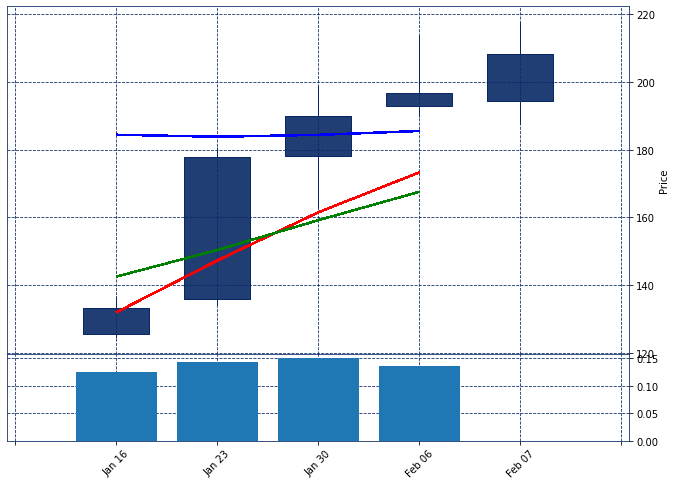

,Open,High,Low,Close,EMA5,EMA8,EMA21,labels,prediction,TwitterSentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
0,125.699997,136.679993,124.309998,133.419998,131.990468,142.541682,184.435702,nn,nn,0.1241,2023-01-16,9.500978,1
1,135.869995,180.679993,134.270004,177.899994,147.293644,150.399084,183.841547,nn,nn,0.1436,2023-01-23,9.500978,1
2,178.050003,199.000000,162.779999,189.979996,161.522428,159.194842,184.399587,nn,nn,0.1497,2023-01-30,9.500978,1
3,193.009995,214.000000,189.550003,196.889999,173.311618,167.571544,185.535079,nn,nn,0.1350,2023-02-06,9.500978,1
4,194.419998,217.649994,187.610001,208.309998,147.293644,150.399084,183.841547,217.649994,203.920976,0.0000,2023-02-07,9.500978,1


In [17]:
#trade = 4
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,
budget=budget,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
trade += 1
df


In [18]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle=entry_candle,#"Current Open"
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final = trades_df_final.sort_values('Datetime', ascending=True)
trades_df_final.tail(5)

--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA5,EMA8,EMA21,labels,prediction,TwitterSentiment,Datetime,profit,trade,Entry,Performance
0,125.699997,136.679993,124.309998,133.419998,131.990468,142.541682,184.435702,nn,nn,0.1241,2023-01-16,9.500978,1,nn,nn
1,135.869995,180.679993,134.270004,177.899994,147.293644,150.399084,183.841547,nn,nn,0.1436,2023-01-23,9.500978,1,nn,nn
2,178.050003,199.000000,162.779999,189.979996,161.522428,159.194842,184.399587,nn,nn,0.1497,2023-01-30,9.500978,1,nn,nn
3,193.009995,214.000000,189.550003,196.889999,173.311618,167.571544,185.535079,nn,nn,0.1350,2023-02-06,9.500978,1,nn,nn
4,194.419998,217.649994,187.610001,208.309998,147.293644,150.399084,183.841547,217.649994,203.920976,0.0000,2023-02-07,9.500978,1,194.419998,485.0


<b>Plot Chart With Labels and Predictions</b>

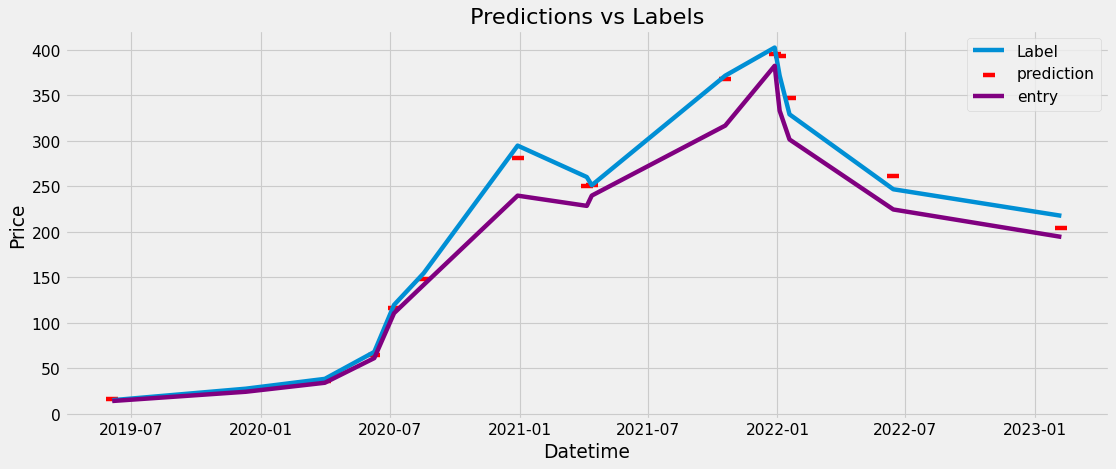

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
figure(figsize=(15, 6), dpi=80)

df_plot = trades_df_final[['Datetime','labels','prediction','Entry']]
df_plot = df_plot[df_plot.labels != 'nn']

x1 = df_plot['labels']
x2 = df_plot['prediction']
entry = df_plot['Entry']
y = df_plot['Datetime']

# plot lines
plt.plot(y, x1, label = "Label") #,s=200,marker='*'
plt.scatter(y, x2, label = "prediction",color='red', s=100,marker='_')
plt.plot(y, entry, label = "entry",color='purple')#,color='blue', s=100,marker=0
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title('Predictions vs Labels')
plt.legend()
plt.show()

<b>Export dataframe with all variables</b>

In [20]:

def ExportFile():
    today = datetime.today().date()

    variables_dict = \
    {
    'model_name':[model_name_],
    'Date':[today],
    'ticker':[ticker],
    'period':[period],
    'api_key':[api_key],
    'sentiment':[sentiment],
    'sentiment_type':[sentiment_type],
    'aggr_function':[aggr_function],
    'formation_window':[formation_window],
    'target_window':[target_window],
    'split_ratio':[split_ratio],
    'test_ratio':[test_ratio],
    'validation_ratio':[validation_ratio],
    'condition':[condition],
    'indicator1':[indicator1],
    'indicator2':[indicator2],
    'indicator3':[indicator3],
    'window_size':[window_size],
    'formation_window':[formation_window],
    'twitter':[twitter],
    'start_date':[start_date],
    'end_date':[end_date],
    'batch_size_train':[batch_size_train],
    'batch_size_valid':[batch_size_valid],
    'shuffle':[shuffle],
    'entry_candle':[entry_candle],
    'excel_reports':[excel_reports],
    'acceptance':[acceptance],
    'penalization':[penalization],
    }

    x_test.to_csv(f'{temp}/{ticker}_test_data.csv')
    x_test_x.to_csv(f'{temp}/{ticker}_x_test_x.csv')
    test_start = len(Dates)-x_test.shape[0]
    Dates_test = Dates[test_start:]
    Dates_test.to_csv(f'{temp}/{ticker}_dates_test.csv')
    Dates.to_csv(f'{temp}/{ticker}_Dates.csv')
    df = pd.DataFrame(variables_dict).transpose()
    df.to_csv(f'{temp}/variables_df.csv')
    return df

df = ExportFile()
df


,0
model_name,tsla_model_2023-03-19_3328.h5
Date,2023-03-19
ticker,tsla
period,1wk
api_key,631505e804ec58.42743136
sentiment,True
sentiment_type,TwitterSentiment
aggr_function,median
formation_window,4
target_window,1


In [29]:
from final_evaluation import MakeSinglePrediction


MakeSinglePrediction = MakeSinglePrediction()
print('penalization: ',penalization)
print('penalization: ',acceptance)
fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date="2019-03-18",
                        end_date="2023-03-18",
                        interval=period, #1wk
                        progress=False,
                        condition=condition,
                        timeperiod1=indicator1,
                        timeperiod2=indicator2,
                        timeperiod3=indicator3,
                        debug=False,
                        budget=10000,
                        penalization=penalization,
                        acceptance=acceptance,
                        entry_candle='Current Close',
                        news_df=news_df,
                        sentiment=sentiment,
                        sentiment_type=sentiment_type,
                        sentiment_aggr=aggr_function)

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.head(formation_window)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method

#final_trade_formation.tail()


penalization:  0
penalization:  0


,Date,Open,High,Low,Close,EMA5,EMA8,EMA21,TwitterSentiment
0,2023-02-20,34.910000,35.049999,33.840000,34.209999,34.952755,34.908640,34.779461,0.178064
1,2023-02-27,34.450001,34.689999,33.000000,34.160000,34.688503,34.742276,34.723146,0.119614
2,2023-03-06,34.240002,34.560001,28.920000,30.270000,33.215669,33.748437,34.318315,0.180243
3,2023-03-13,28.920000,30.090000,27.620001,27.820000,31.417113,32.431006,33.727559,0.274629



Ticker:  bac
1/1 [==============================] - 2s 2s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  27.82
Prediction:  29.19
Expected Market move:  1.37
Expected Profit:  491.75


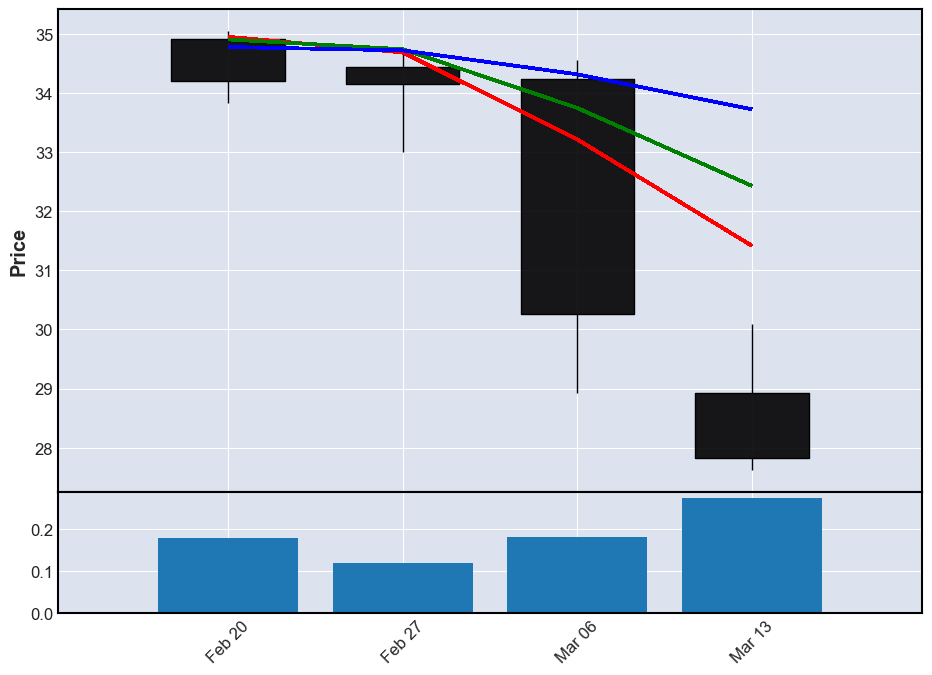

In [30]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart and sentiment
from plotting import PlotCurrentFormation

PlotCurrentFormation(final_trade_formation,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
